# AllenNLP Introduction
This notebook trains a decomposable attention model on the Stanford Natural Language Inference dataset.  


* Install allennlp 
* Configure the model & examine the different abstractions
* Train the model via the comannd line interface
* Evaluate the model via the comannd line interface


In [ ]:
%%bash
pip install allennlp -q --ignore-installed greenlet

# Configuration File

In this example, we'll examine AllenNLP's model configuration file because it displays several different Allen NLP abstractions in one place.   

## DatasetReader

This example reads in the Standford Natural Language Inference (SNLI) dataset.  This dataset is in a json line format with the following fields:

* sentence1: The premise caption that was supplied to the author of the pair.
* sentence2: The hypothesis caption that was written by the author of the pair.
* gold_label: entailment, contridiction, or neutral

The reader does a few things to prep the data.
1. Tokenizes the input sentence pairs
2. Indexes the tokens in both sentences
3. Indexes the lables

> Note: We're using the default tokenizer from SpaCy.  However, the tokenizer is easily replaced.  Note that the tokens are converted to lower case before being indexed.  

## Model

We'll configure the decomposible attention model for the training run.  In AllenNLP, the model extends torch.nn.Module with a custom [forward method](https://allenai.github.io/allennlp-docs/api/allennlp.models.model.html) to plug in to AllenNLP's trainer.

> Note: For a more comprehensive tutorial that includes building your own dataset reader and model, see [An In-Depth Tutorial to AllenNLP (From Basics to ELMo and BERT)](http://mlexplained.com/2019/01/30/an-in-depth-tutorial-to-allennlp-from-basics-to-elmo-and-bert/)

### text_field_embedder

The ```text_field_embedder``` converts the premise and hypothesis sentences to embeddings.  In this case, the model usea pretrained glove embeddings.  We can swap out the embeddings by changing this configuration.  


### initializer

This componment initalizes the models parameters (aka weights) based on a regex pattern.  

### Decomposable attention specific modules

The basic architecture of the model is shown below.  The decomposable attention model has three basic components: attend, compare, and aggregate.  AllenNLP handles these basic components as pytouch modules, which makes the implementation fairly interchangeable.  AllenNLP provides several NLP specific modules, which are documented [here](https://allenai.github.io/allennlp-docs/api/allennlp.modules.html).

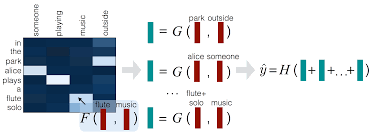

For more information see the [models documentation](https://allenai.github.io/allennlp-docs/api/allennlp.models.decomposable_attention.html#module-allennlp.models.decomposable_attention).

## Iterator

The iterator feeds the input data to the model.  While this sounds simple, its not becuase the textual data lengths varies.  The iterator handles the padding the input so that the input data fits in the model. 

The example uses a Bucket Iterator: 

> An iterator which by default, pads batches with respect to the maximum input lengths per batch. Additionally, you can provide a list of field names and padding keys which the dataset will be sorted by before doing this batching, causing inputs with similar length to be batched together, making computation more efficient (as less time is wasted on padded elements of the batch).

## Trainer

This component configures the training session.  We'll run the training for at least 10 and stop early if the accuracy hasn't improved for 3 epochs.  The configuration also includes the gradient descent settings, like the gradient descent optizimer.

In [ ]:
%%writefile snli_basic.conf
// Configuraiton for a textual entailment model based on:
//  Parikh, Ankur P. et al. “A Decomposable Attention Model for Natural Language Inference.” EMNLP (2016).
{
  "dataset_reader": {
    "type": "snli",
    "token_indexers": {
      "tokens": {
        "type": "single_id",
        "lowercase_tokens": true
      }
    },
    "tokenizer": {
      "end_tokens": ["@@NULL@@"]
    }
  },
  "train_data_path": "../input/snli-jsonl/snli_1.0_train.jsonl",
  "validation_data_path": "../input/snli-jsonl/snli_1.0_dev.jsonl",
  "model": {
    "type": "decomposable_attention",
    "text_field_embedder": {
      "token_embedders": {
        "tokens": {
            "type": "embedding",
            "projection_dim": 200,
            "pretrained_file": "../input/glove6b/glove.6B.300d.txt",
            "embedding_dim": 300,
            "trainable": false
        }
      }
    },
    "attend_feedforward": {
      "input_dim": 200,
      "num_layers": 2,
      "hidden_dims": 200,
      "activations": "relu",
      "dropout": 0.2
    },
    "similarity_function": {"type": "dot_product"},
    "compare_feedforward": {
      "input_dim": 400,
      "num_layers": 2,
      "hidden_dims": 200,
      "activations": "relu",
      "dropout": 0.2
    },
    "aggregate_feedforward": {
      "input_dim": 400,
      "num_layers": 2,
      "hidden_dims": [200, 3],
      "activations": ["relu", "linear"],
      "dropout": [0.2, 0.0]
    },
     "initializer": [
      [".*linear_layers.*weight", {"type": "xavier_normal"}],
      [".*token_embedder_tokens\\._projection.*weight", {"type": "xavier_normal"}]
     ]
   },
  "iterator": {
    "type": "bucket",
    "sorting_keys": [["premise", "num_tokens"], ["hypothesis", "num_tokens"]],
    "batch_size": 64
  },
  "trainer": {
    "num_epochs": 10,
    "patience": 3,
    "num_serialized_models_to_keep": 4,
    "cuda_device": 0,
    "grad_clipping": 5.0,
    "validation_metric": "+accuracy",
    "optimizer": {
      "type": "adagrad"
    }
  }
}

# Train (via CLI)

allennlp train --help


```
usage: allennlp train [-h] -s SERIALIZATION_DIR [-r] [-f] [-o OVERRIDES]
                      [--file-friendly-logging]
                      [--include-package INCLUDE_PACKAGE]
                      param_path

Train the specified model on the specified dataset.

positional arguments:
  param_path            path to parameter file describing the model to be
                        trained

optional arguments:
  -h, --help            show this help message and exit
  -s SERIALIZATION_DIR, --serialization-dir SERIALIZATION_DIR
                        directory in which to save the model and its logs
  -r, --recover         recover training from the state in serialization_dir
  -f, --force           overwrite the output directory if it exists
  -o OVERRIDES, --overrides OVERRIDES
                        a JSON structure used to override the experiment
                        configuration
  --file-friendly-logging
                        outputs tqdm status on separate lines and slows tqdm
                        refresh rate
  --include-package INCLUDE_PACKAGE
                        additional packages to include
```

In [ ]:
%%bash
allennlp train -s snli_basic snli_basic.conf

# Evaluate (via CLI)

Once the training is completed, the model is saved to snli_basic/model.tar.gz.  The logs and checkpoints are also saved to the SERIALIZATION_DIR.

In [ ]:
%%bash
allennlp evaluate --output-file snli_basic_results.jsonl snli_basic/model.tar.gz ../input/snli-jsonl/snli_1.0_test.jsonl

In [ ]:
!head snli_basic_results.jsonl

# Vocabulary 

Lets look at the vocabulary before moving on.  This file will look different in the next example because the next example will use wordpiece tokens and BERT embeddings. 

In [ ]:
import pandas as pd
pd.read_csv('snli_basic/vocabulary/tokens.txt',sep=' ',header=None,names=['token'])